In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import open3d as o3d

from open3D_tools import create_open3D_frame,create_open3D_point,create_open3d_ray, create_open3D_camera

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
f_x = 1000
f_y = 1000

W = 1920
H = 1080

c_x = W/2
c_y = H/2

K = np.array([[f_x, 0, c_x],[0, f_y, c_y],[0, 0, 1]])


In [5]:
def project_point(K, camera_pose, point):
    # create homogeneous point 
    point = np.hstack([point, 1])   
    point_in_camera_coords = np.linalg.inv(camera_pose) @ point.T
    pixels = K @ point_in_camera_coords[:3]
    pixels /= pixels[2]
    return pixels[:2]

def ray_from_pixels(K, pixels):
    pixels = np.hstack([pixels, 1])
    ray = np.linalg.inv(K) @ pixels
    ray /= np.linalg.norm(ray)
    return ray

In [6]:
def create_camera_pose(min_radius, max_radius):
    radius = np.random.uniform(min_radius, max_radius)
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi / 2)  # Spherical cap

    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    # Camera position
    position = np.array([x, y, z])
    # Look at the origin
    target = np.array([0, 0, 0])

    # Define the up vector
    target = np.random.uniform(-0.5, 0.5, size=3)
    up = np.array([0, 0, 1])

    # Create the camera pose
    # Create the orientation of the camera
    forward = (target - position) / np.linalg.norm(target - position)
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    up = np.cross(forward, right)

    # Create the camera pose matrix
    camera_pose = np.eye(4)
    camera_pose[:3, :3] = np.vstack([right, up, forward]).T
    camera_pose[:3, 3] = position

    return camera_pose



def sample_camera_poses(min_radius, max_radius, num_samples):
    poses = []
    while len(poses) < num_samples:
        pose = create_camera_pose(min_radius, max_radius)


        projected_origin = project_point(K, pose, np.array([0, 0, 0]))
        # check origin is in camera frustum
        if projected_origin[0] > 0 and projected_origin[0] < W and projected_origin[1] > 0 and projected_origin[1] < H:
            pass
        else:
            continue
        
        poses.append(pose)

    return poses

# Example usage
min_radius = 0.3
max_radius = 2
num_samples = 4
camera_poses = sample_camera_poses(min_radius, max_radius, num_samples)


In [7]:
# for each camera pose, project the origin 

projected_origins = []
for pose in camera_poses:
    projected_origin = project_point(K, pose, np.array([0, 0, 0]))
    projected_origins.append(projected_origin)



In [8]:
# visualize camera poses
open_3d_elements = []
for pixels, pose in zip(projected_origins, camera_poses):
    camera = create_open3D_camera(pose,K)
    open_3d_elements.extend(camera)
    ray = ray_from_pixels(K, pixels)
    ray = pose[:3,:3] @ ray
    ray = create_open3d_ray(ray,pose[:3,3])
    open_3d_elements.append(ray)


o3d.visualization.draw_geometries(open_3d_elements)

In [9]:
sigma = 5
# add gaussian noise to the pixel locations 
noisy_pixels = []
for pixels in projected_origins:
    noisy_pixels.append(pixels + np.random.normal(0, sigma, size=2))
    print(f"pixel = {pixels}, noisy pixel = {noisy_pixels[-1]}")




pixel = [1218.73955151  481.87795509], noisy pixel = [1220.8141018   476.98144226]
pixel = [573.54763842 295.32102891], noisy pixel = [568.28016364 299.87838345]
pixel = [741.69260935 734.04303984], noisy pixel = [743.59139456 737.01801064]
pixel = [1242.8403234    90.40749538], noisy pixel = [1242.58962502   85.07038065]


In [10]:
# visualize noisy rays
open_3d_elements = []
for pixels, pose in zip(noisy_pixels, camera_poses):
    camera = create_open3D_camera(pose,K)
    open_3d_elements.extend(camera)
    ray = ray_from_pixels(K, pixels)
    ray = pose[:3,:3] @ ray
    ray = create_open3d_ray(ray,pose[:3,3])
    open_3d_elements.append(ray)
    
o3d.visualization.draw_geometries(open_3d_elements)



In [11]:
def multiview_midpoint_triangulation(pixel_coordinates,camera_poses, K):
    lhs = np.zeros((3,3))
    rhs = np.zeros(3)
    for pixel, pose in zip(pixel_coordinates, camera_poses):
        ray_in_camera = ray_from_pixels(K, pixel)
        ray_in_world = pose[:3,:3] @ ray_in_camera
        ray_in_world /= np.linalg.norm(ray_in_world)
        ray_in_world = ray_in_world.reshape(3,1)

        lhs += (np.eye(3) - ray_in_world @ ray_in_world.T)
        rhs += (np.eye(3) - ray_in_world @ ray_in_world.T) @ pose[:3,3]

    return np.linalg.inv(lhs) @ rhs

In [12]:
mvmp_point = multiview_midpoint_triangulation(noisy_pixels, camera_poses, K)
print(f"multiview midpoint triangulation = {mvmp_point}")

multiview midpoint triangulation = [ 0.00041054 -0.00130017 -0.00341601]


In [13]:
# visualize the triangulated point and all rays and cameras

open_3d_elements = []
for pixels, pose in zip(noisy_pixels, camera_poses):
    camera = create_open3D_camera(pose,K)
    open_3d_elements.extend(camera)
    ray = ray_from_pixels(K, pixels)
    ray = pose[:3,:3] @ ray
    ray = create_open3d_ray(ray,pose[:3,3])
    open_3d_elements.append(ray)

point = create_open3D_point(mvmp_point)
open_3d_elements.append(point)

o3d.visualization.draw_geometries(open_3d_elements)

In [14]:
def DLT_triangulation(pixel_coordinates,camera_poses, K):
    A = np.zeros((2*len(pixel_coordinates), 4))
    for i, (pixel, pose) in enumerate(zip(pixel_coordinates, camera_poses)):
        M = K @ np.linalg.inv(pose)[:3,:]
        u,v = pixel
        A[2*i] = u * M[2] - M[0]
        A[2*i+1] = v * M[2] - M[1]


    u, s, vh = np.linalg.svd(A)
    point = vh[-1]
    point /= point[3]
    return point[:3]


In [15]:
point = DLT_triangulation(noisy_pixels, camera_poses, K)

print(point)

[ 0.00046825 -0.00116131 -0.00332731]


In [ ]:
import torch 

# optimize the triangulation using pytorch on the reprojection error
def reprojection_error_torch(pixel, pose, point, K):
    pose = torch.linalg.inv(pose)
    projected_point = K @ (pose[:3,:3] @ point + pose[:3,3])
    projected_point =  projected_point[:2] / projected_point[2]
    error = torch.linalg.norm(pixel - projected_point, ord=2)
    return error

def reprojection_errors_torch(pixels, camera_poses, point, K):
    avg_error = torch.tensor(0.0)
    for pixel, pose in zip(pixels, camera_poses):
        error = reprojection_error_torch(pixel, pose, point, K)
        avg_error += error
    return avg_error / len(pixels)

def loss_function_torch(point, pixel_coordinates, camera_poses, K):
    return reprojection_errors_torch(pixel_coordinates, camera_poses, point, K)

def bundle_adjustment_triangulation_torch(pixel_coordinates,camera_poses, K):

    initial_guess = multiview_midpoint_triangulation(pixel_coordinates, camera_poses, K)
    best_guess = torch.tensor(initial_guess, requires_grad=True)
    K = torch.tensor(K)
    camera_poses = [torch.tensor(pose) for pose in camera_poses]
    pixel_coordinates = [torch.tensor(pixel) for pixel in pixel_coordinates]


    optimizer = torch.optim.Adam([best_guess], lr=0.0001)

    for i in range(50):
        optimizer.zero_grad()
        loss = loss_function_torch(best_guess, pixel_coordinates, camera_poses, K)
        if i % 10 == 0:
            # print(f"{i} - loss = {loss}")
            pass
        
        loss.backward()
        # print gradients for each variable
        optimizer.step()
    return best_guess.detach().numpy()



In [ ]:
point = bundle_adjustment_triangulation_torch(noisy_pixels, camera_poses, K)

print(point)

In [26]:

n_cameras = [2,3,4,5]
min_radius = 0.3
max_radius = 2
num_samples = 100

sigmas = [0, 1, 5, 10]
experiment_dicts = []
for n_camera in n_cameras:
    print(f"n_camera = {n_camera}")
    for sigma in sigmas:
        print(f"sigma = {sigma}")
        for i in range(num_samples):
            camera_poses = sample_camera_poses(min_radius, max_radius, n_camera)
            pixels = []
            for pose in camera_poses:
                pixels.append(project_point(K, pose, np.array([0, 0, 0])))
            
            noisy_pixels = []
            for pixels in pixels:
                noisy_pixels.append(pixels + np.random.normal(0, sigma, size=2))

            mvmp_point = multiview_midpoint_triangulation(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(mvmp_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "mvmp"})
            
            dlt_point  = DLT_triangulation(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(dlt_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "dlt"})

            bundle_point = bundle_adjustment_triangulation_torch(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(bundle_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "bundle"})
            




n_camera = 2
sigma = 0
sigma = 1
sigma = 5
sigma = 10
n_camera = 3
sigma = 0
sigma = 1
sigma = 5
sigma = 10
n_camera = 4
sigma = 0
sigma = 1
sigma = 5
sigma = 10
n_camera = 5
sigma = 0
sigma = 1
sigma = 5
sigma = 10


In [27]:
import pandas as pd
df = pd.DataFrame(experiment_dicts)

# average error for each method, sigma and number of cameras


# scale error to have it in mm
df
df["error"] = df["error"] * 1000


Text(0.5, 1.0, 'Comparison of different triangulation methods')

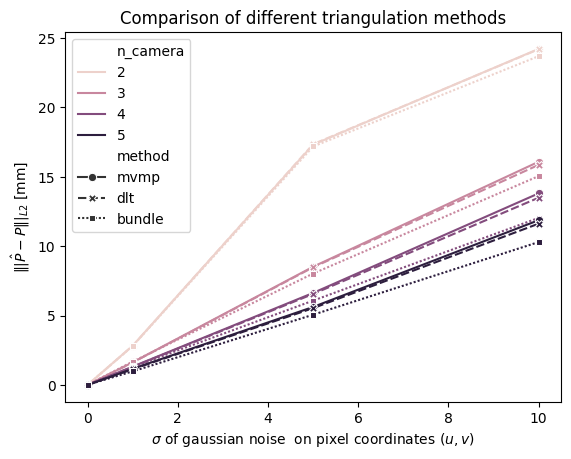

In [42]:
# plot multiline with sigma on x axis and different lines for n_camera
import seaborn as sns
import matplotlib.pyplot as plt

# add dots on the line
# stddev  on each dot
sns.lineplot(data=df, x="sigma", y="error", hue="n_camera", style="method", markers=True,errorbar=None)
plt.xlabel("$\sigma$ of gaussian noise  on pixel coordinates $(u,v)$")
plt.ylabel("$ \||\hat{P} - P\||_{L2}$ [mm]")
plt.title("""Comparison of different triangulation methods""")




/tmp/ipykernel_60003/1313259072.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Z[i,j] = reprojection_errors_torch(torch.tensor(noisy_pixels), [torch.tensor(pose) for pose in camera_poses], torch.tensor(point), torch.tensor(K))


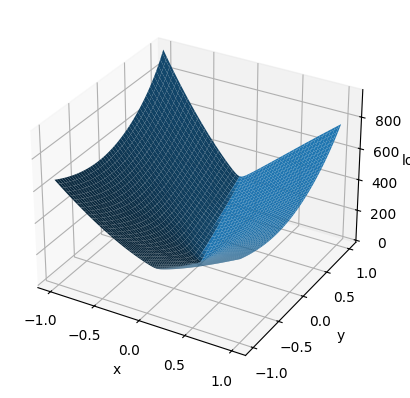

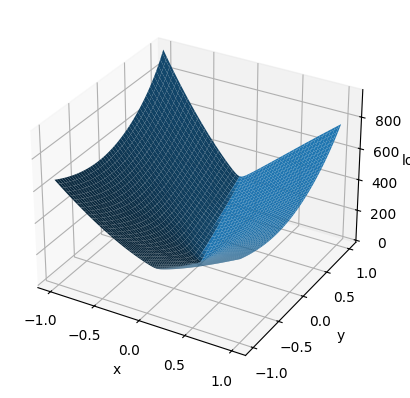

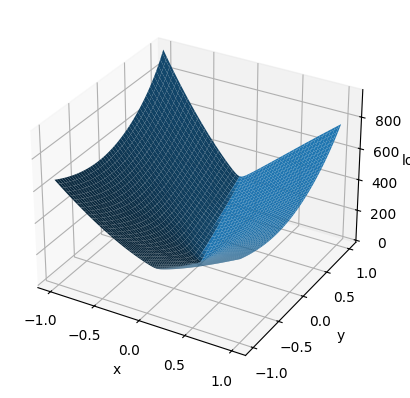

In [25]:
# visualize the loss landscape

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

initial_guess = multiview_midpoint_triangulation(noisy_pixels, camera_poses, K)

for i in range(3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i,j], Y[i,j], initial_guess[2]])
            Z[i,j] = reprojection_errors_torch(torch.tensor(noisy_pixels), [torch.tensor(pose) for pose in camera_poses], torch.tensor(point), torch.tensor(K))
    ax.plot_surface(X, Y, Z)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("loss")
    plt.show()
